In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

## Importing data

In [2]:
headers = ['T_Out_AVG', 'T_1ST_AVG', 'T_MBR_AVG', 
           'T_ALT_AVG', 'T_Plenum_AVG', 'RH_Out_AVG', 
           'RH_1ST_AVG', 'RH_MBR_AVG', 'RH_ALT_AVG', 'KWH_TOTAL_TOT']

# Filter the data so that only the selected columns remain
df = pd.read_csv('House_12.csv', usecols=headers)

# Print the information of df
print(df.info())

# Print the head of df
print(df.head())

# Filter the NaNs
df = df.dropna()

# Print the info of df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14738 entries, 0 to 14737
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_Out_AVG      2070 non-null   float64
 1   T_1ST_AVG      2070 non-null   float64
 2   T_MBR_AVG      2070 non-null   float64
 3   T_ALT_AVG      2070 non-null   float64
 4   T_Plenum_AVG   2070 non-null   float64
 5   RH_Out_AVG     2070 non-null   float64
 6   RH_1ST_AVG     2070 non-null   float64
 7   RH_MBR_AVG     2070 non-null   float64
 8   RH_ALT_AVG     2070 non-null   float64
 9   KWH_TOTAL_TOT  2070 non-null   float64
dtypes: float64(10)
memory usage: 1.1 MB
None
   T_Out_AVG  T_1ST_AVG  T_MBR_AVG  T_ALT_AVG  T_Plenum_AVG  RH_Out_AVG  \
0       86.2      150.5      150.0      148.9         153.9       23.72   
1       87.3      148.7      147.1      145.8         147.7       23.42   
2       87.4      143.9      144.3      141.8         126.5       23.37   
3       87.2     

## Filter the data

In [3]:
from utils import filter_outliers

# Filter the outliers
df = filter_outliers(df, z_thresh=3)

## Visualizing the data

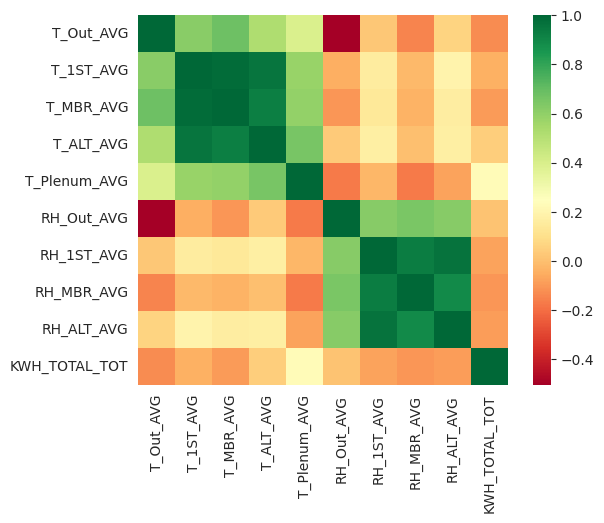

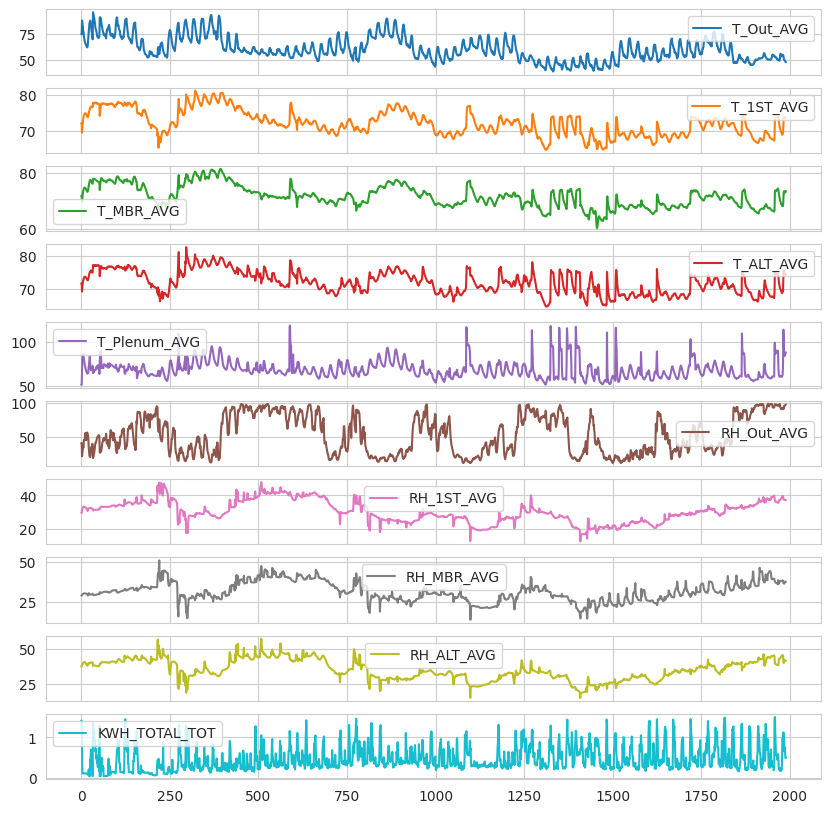

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a correlation heatmap
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.show()

# Plot the time series
df.plot(subplots=True, figsize=(10, 10))
plt.show()

## Creating the features and labels

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class HouseDataset(Dataset):
    """House dataset."""
    
    def __init__(self, df, split: str = 'train'):
        self.X = df.drop(columns=['T_1ST_AVG']).to_numpy()
        self.y = df['T_1ST_AVG'].to_numpy()
        self.split = split
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, shuffle=False)
        
        print('X_train shape: {}'.format(self.X_train.shape))
        print('y_train shape: {}'.format(self.y_train.shape))
        print('X_test shape: {}'.format(self.X_test.shape))
        print('y_test shape: {}'.format(self.y_test.shape))
        
        
        # Scale the data
        self.scaler = MinMaxScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
    def __len__(self):
        if self.split == 'train':
            return len(self.X_train)
        elif self.split == 'test':
            return len(self.X_test)
        else:
            raise ValueError('Invalid split type!')
        
    def __getitem__(self, idx):
        if self.split == 'train':
            # Convert the numpy arrays to PyTorch tensors
            return torch.from_numpy(self.X_train[idx]).float(), torch.tensor(self.y_train[idx]).float().unsqueeze(0)
        elif self.split == 'test':
            # Convert the numpy arrays to PyTorch tensors
            return torch.from_numpy(self.X_test[idx]).float(), torch.tensor(self.y_test[idx]).float().unsqueeze(0)
        else:
            raise ValueError('Invalid split type!')
        

In [6]:
# Create the dataset
train_ds = HouseDataset(df, split='train')
test_ds = HouseDataset(df, split='test')

# Create the dataloaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# Print the shapes of the data
for x, y in test_dl:
    print(x.shape, y.shape)
    print(x.dtype, y.dtype)
    break

X_train shape: (1592, 9)
y_train shape: (1592,)
X_test shape: (398, 9)
y_test shape: (398,)
X_train shape: (1592, 9)
y_train shape: (1592,)
X_test shape: (398, 9)
y_test shape: (398,)
torch.Size([32, 9]) torch.Size([32, 1])
torch.float32 torch.float32


In [7]:
# Create the regression model
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionModel(nn.Module):
    """Regression model."""
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    

In [8]:
# Create the model
model = RegressionModel(input_dim=9, output_dim=1)

# Print the model
print(model)


RegressionModel(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
# Train the model
import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:

# Define the number of epochs
n_epochs = 100

for epoch in range(n_epochs):
    # Set the model to train mode
    model.train()
    
    # Initialize the running loss
    running_loss = 0.0
    
    # Iterate over the training batches
    for i, (x, y) in enumerate(train_dl):
        # Reset the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x)
        
        # Compute the loss
        loss = criterion(y_pred, y)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
        
    # Evaluate the model
    model.eval()
    
    # Initialize the validation loss
    val_loss = 0.0
    
    # Iterate over the validation batches
    for i, (x, y) in enumerate(test_dl):
        # Forward pass
        y_pred = model(x)
        
        # Compute the loss
        loss = criterion(y_pred, y)
        
        # Update the validation loss
        val_loss += loss.item()
        
    # Print the metrics
    print('Epoch {}, Loss (train/val): {:.3f}/{:.3f}'.format(
        epoch, running_loss / len(train_dl), val_loss / len(test_dl)))

Epoch 0, Loss (train/val): 5206.502/4671.955
Epoch 1, Loss (train/val): 4345.717/2981.365
Epoch 2, Loss (train/val): 1725.203/309.508
Epoch 3, Loss (train/val): 179.853/104.395
Epoch 4, Loss (train/val): 135.570/94.630
Epoch 5, Loss (train/val): 126.004/87.195
Epoch 6, Loss (train/val): 116.924/81.762
Epoch 7, Loss (train/val): 107.256/75.286
Epoch 8, Loss (train/val): 97.259/69.743
Epoch 9, Loss (train/val): 88.317/63.765
Epoch 10, Loss (train/val): 79.745/58.768
Epoch 11, Loss (train/val): 71.242/52.931
Epoch 12, Loss (train/val): 63.380/48.274
Epoch 13, Loss (train/val): 55.983/42.799
Epoch 14, Loss (train/val): 48.389/37.812
Epoch 15, Loss (train/val): 41.783/33.296
Epoch 16, Loss (train/val): 35.313/28.609
Epoch 17, Loss (train/val): 29.340/23.564
Epoch 18, Loss (train/val): 24.080/19.705
Epoch 19, Loss (train/val): 19.474/16.443
Epoch 20, Loss (train/val): 15.535/12.924
Epoch 21, Loss (train/val): 12.060/10.016
Epoch 22, Loss (train/val): 9.351/8.320
Epoch 23, Loss (train/val): 7

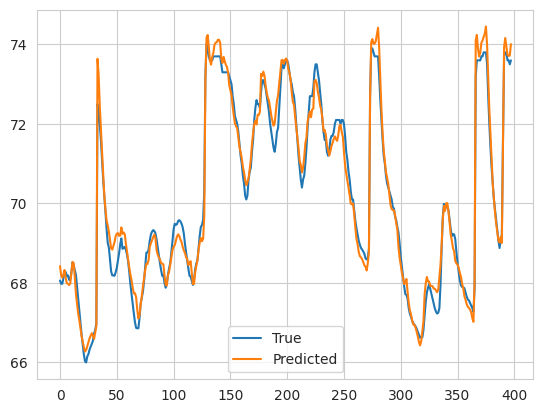

In [11]:
# Visualize the predictions
import matplotlib.pyplot as plt

true_time_series = df['T_1ST_AVG'].to_numpy()
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

# Set the model to eval mode
model.eval()
for x, y in test_dl:
    y_pred = model(x)
    y_pred = y_pred.detach().numpy().flatten()
    y_true = y.detach().numpy().flatten()
    break

# Plot the time series
plt.plot(y_true, label='Ground Truth')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()